In [3]:
import os
import glob
import datetime
import importlib
import statistics
import numpy as np
import pandas as pd
from marcap import marcap_data
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from prettytable import PrettyTable

In [4]:
#import models.pbr_gpa as model # 1/PBR + GP/A
#import models.gpa as model
#import models.ncav as model # NCAV
#import models.super_value as model # PBR + PCR + PER + PSR
#import models.super_quality as model
#import models.lu_zhang as model
#import models.pbr as model
#import models.pcr as model
import models.per as model
#import models.psr as model
#import models.pbr_psr as model

importlib.reload(model)

<module 'models.per' from '/home/pi/Documents/stock-backtesting/backtest-playground/quantitative-value/models/per.py'>

In [134]:
#DATA_DIR = '../data/quarterly/2-5-8-11' # quarter
# DATA_DIR = '../data/half-year/2-8' # half year
DATA_DIR = '../data/yearly/8-1'
REBALANCE = 1 # 1: yearly, 2: half-yearly 4: quarterly

In [126]:
MIN_MARKET_CAP = 0.0
MAX_MARKET_CAP = 1.0
MARKET_CAP_STEP = 0.2

In [127]:
MIN_PER_RANK = 0.0
MAX_PER_RANK = 1.0
PER_RANK_STEP = 0.2

In [135]:
def get_cagr(min_market_cap, max_market_cap, min_per_rank, max_per_rank):
    df_account = pd.DataFrame(columns=['start_date', 'end_date', 'filepath'])
    filepaths = glob.glob(DATA_DIR + "/*.csv")
    filepaths = sorted(filepaths)

    days = []
    for i in range(len(filepaths)):
        if i < len(filepaths) - 1: # exclude last item
            start_date =  os.path.basename(filepaths[i])[:-4]
            end_date =  os.path.basename(filepaths[i + 1])[:-4]

            day = {'start_date':start_date, 'end_date':end_date, 'filepath':filepaths[i]}
            days.append(day)

    df_account = df_account.append(days)
    
    # 연도별 종목을 구한다.
    df_account['stocks'] = df_account.apply(lambda x: model.get_stocks(x.filepath, x.start_date, 
                                                                       min_market_cap, max_market_cap,
                                                                       min_per_rank, max_per_rank, verbose=False), axis=1)
    
    
    # 연도별 수익률을 구한다.
    df_account['yield'] = 0.0
    df_account['yields'] = 0.0
    df_account['yields'] = df_account['yields'].astype('object')
    df_account['delisted'] = 0
    df_account['delisted_stocks'] = df_account['yields'].astype('object')

    for i in range(len(filepaths)):
        if i < len(filepaths) - 1: # exclude last item
            start_date = df_account.iloc[i].start_date
            end_date = df_account.iloc[i].end_date

            df_this_year = pd.read_csv(filepaths[i], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
            df_next_year = pd.read_csv(filepaths[i + 1], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]

            stocks = df_account.iloc[i].stocks   
            yields = []

            # 종목별 수익률, 상장폐지 기업 수를 구한다.
            delisted = 0 # 상장폐지 기업 수
            delisted_stocks  = []
            for stock in stocks:
                start_price = df_this_year[df_this_year['종목코드'] == stock]['주가'].iloc[0]
                end_price = df_next_year[df_next_year['종목코드'] == stock]['주가']

                if len(end_price) == 0:
                    end_price = 0
                else:                    
                    end_price = end_price.fillna(0) 
                    end_price = end_price.iloc[0]

                if end_price == 0: # 가격 정보가 없을 경우 상폐
                    delisted += 1
                    delisted_stocks.append(stock)

                # get yield
                yields.append(end_price / start_price)

            # stock 수익률들의 avg가 total 수익률이 된다. (동일 비중이기 때문에)
            mean_yields = statistics.mean(yields)
            df_account.at[i, 'yield'] = mean_yields
            df_account.at[i, 'yields'] = yields
            df_account.at[i, 'delisted'] = delisted
            df_account.at[i, 'delisted_stocks'] = delisted_stocks

            print(start_date, '~', end_date, ":", mean_yields)
            
    df_account['total'] = df_account['yield'].cumprod()
    df_account['cagr'] = 0.0
    
    cagr = pow(df_account['total'][len(df_account) - 1], 1/(len(df_account)/REBALANCE))
    
    return cagr

In [140]:
total_cagrs = []

In [141]:
for market_cap in reversed(np.arange(MIN_MARKET_CAP, MAX_MARKET_CAP, MARKET_CAP_STEP)):
    min_market_cap = market_cap
    max_market_cap = min_market_cap + MARKET_CAP_STEP
    
    cagrs = []
    
    for per_rank in np.arange(MIN_PER_RANK, MAX_PER_RANK, PER_RANK_STEP):
        min_per_rank = per_rank
        max_per_rank = min_per_rank + PER_RANK_STEP
        
        print(min_market_cap, max_market_cap, min_per_rank, max_per_rank)
        cagr = get_cagr (min_market_cap, max_market_cap, min_per_rank, max_per_rank)
        print(cagr - 1.0)
        cagrs.append(cagr)
        
    total_cagrs.append(cagrs)

0.8 1.0 0.0 0.2
2002-08-01 선정 기업 수 31
2003-08-01 선정 기업 수 37
2004-08-02 선정 기업 수 40
2005-08-01 선정 기업 수 44
2006-08-01 선정 기업 수 45
2007-08-01 선정 기업 수 47
2008-08-01 선정 기업 수 51
2009-08-03 선정 기업 수 45
2010-08-02 선정 기업 수 50
2011-08-01 선정 기업 수 57
2012-08-01 선정 기업 수 55
2013-08-01 선정 기업 수 57
2014-08-01 선정 기업 수 57
2015-08-03 선정 기업 수 61
2016-08-01 선정 기업 수 65
2017-08-01 선정 기업 수 70
2018-08-01 선정 기업 수 69
2002-08-01 ~ 2003-08-01 : 0.9619906155960322
2003-08-01 ~ 2004-08-02 : 1.1646209843965423
2004-08-02 ~ 2005-08-01 : 1.8674844753029292
2005-08-01 ~ 2006-08-01 : 1.19783720561213
2006-08-01 ~ 2007-08-01 : 2.5411683509390945
2007-08-01 ~ 2008-08-01 : 0.685255561122498
2008-08-01 ~ 2009-08-03 : 0.9604275410643124
2009-08-03 ~ 2010-08-02 : 1.0090332371322912
2010-08-02 ~ 2011-08-01 : 1.3467218206802851
2011-08-01 ~ 2012-08-01 : 0.7776657564371641
2012-08-01 ~ 2013-08-01 : 1.2569136324225487
2013-08-01 ~ 2014-08-01 : 1.0711917322621913
2014-08-01 ~ 2015-08-03 : 1.1482479094297515
2015-08-03 ~ 2016-08-01 : 0.

In [142]:
total_cagrs

[[1.0974241044989892,
  1.0841473493745875,
  1.051482041384385,
  1.0506261236143417,
  1.0406799919598222],
 [1.0998082109852698,
  1.0608387710462863,
  1.027736284122886,
  1.0146281453554826,
  0.9849929223132942],
 [1.0954616163075475,
  1.039460202071198,
  1.050737266863746,
  1.0431075917635284,
  1.021004081902358],
 [1.1586081655006188,
  1.130098301410705,
  1.105296340137608,
  1.0627338222695677,
  1.0870638047777772],
 [1.2927633034019785,
  1.2084404333073264,
  1.231286042758619,
  1.2132184555670449,
  1.23994333254385]]

In [144]:
total_cagrs = np.array(total_cagrs)

In [148]:
norm = plt.Normalize(total_cagrs.min(), total_cagrs.max())
cmap = plt.get_cmap('Greens')
cell_colors = cmap(norm(total_cagrs))

In [155]:
cell_text = [['%.2f%%' % ((j - 1.0)*100.0) for j in i] for i in total_cagrs]

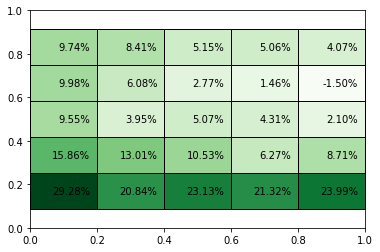

In [156]:
the_table=plt.table(cellText=cell_text, loc='center', cellColours=cell_colors)
the_table.scale(1, 3)
plt.show()